## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score, recall_score

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [61]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
59900,00014790_008.png,Consolidation,8,14790,66,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014790_008.png
19415,00005145_002.png,No Finding,2,5145,51,F,PA,2048,2500,0.171,0.171,NaN,/data/images_003/images/00005145_002.png
36285,00009584_001.png,No Finding,1,9584,30,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009584_001.png


In [62]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo


# Replace the elements of 'Finding Labels' column by a list with the deceases
for i in range (len(all_xray_df)) :
    all_xray_df['Finding Labels'][i] = all_xray_df['Finding Labels'][i].split('|')

#  Create a list with all labels   
labels = []
for i in all_xray_df['Finding Labels'] :
    for label in i :
        if label not in labels :
            labels.append(label)
            
# Create columns by decease with binary indicators        
for label in labels :
    label_values = []
    for i in all_xray_df['Finding Labels'] :
        if label in i :
            label_values.append(1)
        else :
            label_values.append(0)
    all_xray_df[label] = label_values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [63]:
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
64404,00015895_008.png,"[Edema, Effusion, Infiltration]",8,15895,32,M,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,1,0
66572,00016468_001.png,[Infiltration],1,16468,53,M,PA,2992,2991,0.143,...,1,0,0,0,0,0,0,0,0,0
9287,00002423_000.png,[No Finding],0,2423,57,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
17587,00004746_003.png,"[Cardiomegaly, Effusion, Mass]",3,4746,36,F,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
98950,00026167_004.png,[Effusion],4,26167,18,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0


In [64]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']

## Create your training and testing data:

In [65]:
def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_df, valid_df = train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[column_name])
    ## making equal proportions of Pneumonia in both sets!
    # traing data
    p_inds = train_df[train_df[column_name] == 1].index.tolist()
    np_inds = train_df[train_df[column_name] ==0].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # validation data
    p_inds = valid_df[valid_df[column_name]==1].index.tolist()
    np_inds = valid_df[valid_df[column_name]==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    return train_df, valid_df

In [66]:
train_data, val_data = create_splits(all_xray_df, 0.2, 'pneumonia_class')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [67]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(dataframe, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    

     # Todo
    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe=dataframe, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         target_size = img_size, 
                                         batch_size = batch_size
                                         )
    
    return train_gen


def make_val_gen(dataframe, img_size, batch_size):

    # Todo
    my_val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=dataframe, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         target_size = img_size, 
                                         batch_size = batch_size
                                         )
    
    return val_gen

In [68]:
batch_size = 64
img_size = (224, 224)

train_gen = make_train_gen(train_data, img_size, batch_size)
val_gen = make_val_gen(val_data, img_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [69]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

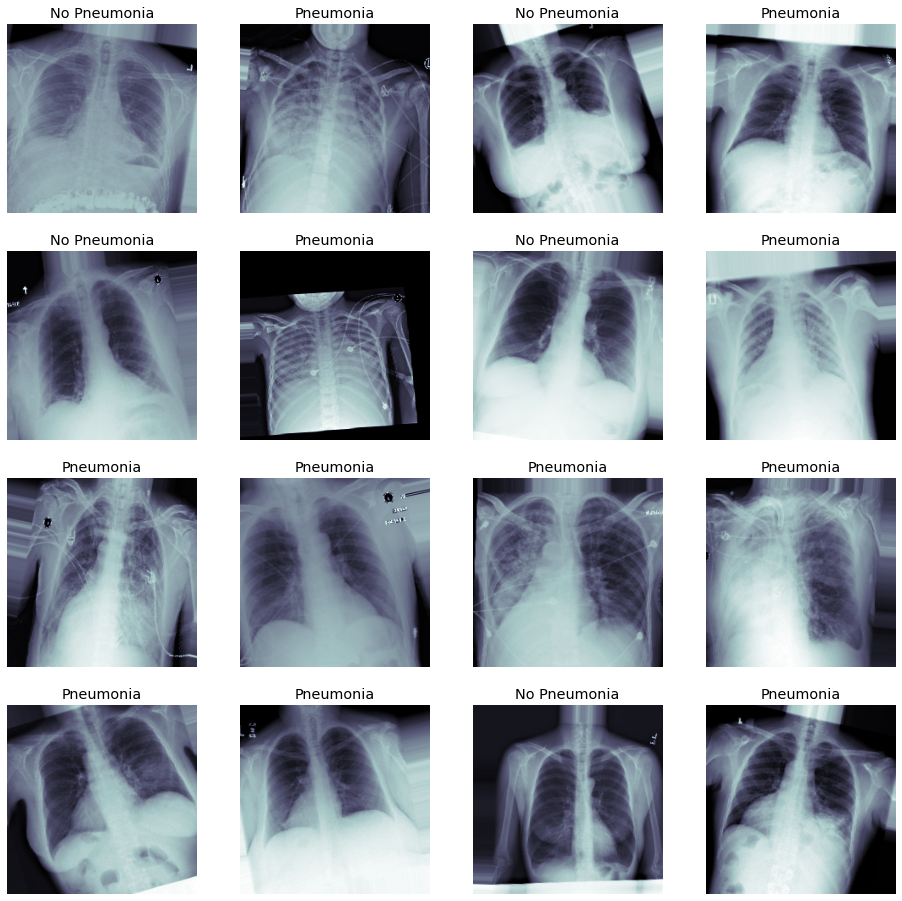

In [70]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [71]:
def load_pretrained_model():
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    return vgg_model


In [72]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    my_model.add(load_pretrained_model())
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model


my_model = build_my_model()
my_model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
___________________________________

In [73]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo



weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_binary_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'auto', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_binary_accuracy', 
                       mode= 'auto', 
                       patience=10, restore_best_weights = True)



callbacks_list = [checkpoint, early]

### Start training! 

In [74]:
## train your model

# Todo
#tf.random.set_seed(400)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.9, name='Adam')

optimizer = 'Adam' #Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_model.fit_generator(train_gen, validation_data = (valX, valY), 
                                  epochs = 10, callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.8291 - binary_accuracy: 0.5114 - val_loss: 0.6355 - val_binary_accuracy: 0.6875

Epoch 00001: val_binary_accuracy improved from -inf to 0.68750, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6814 - binary_accuracy: 0.5607 - val_loss: 0.6511 - val_binary_accuracy: 0.7031

Epoch 00002: val_binary_accuracy improved from 0.68750 to 0.70312, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6720 - binary_accuracy: 0.5961 - val_loss: 0.5983 - val_binary_accuracy: 0.7656

Epoch 00003: val_binary_accuracy improved from 0.70312 to 0.76562, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
36/36 [==============================] - 60s 2s/step - loss: 0.6580 - binary_accuracy: 0.6175 - val_loss: 0.6554 - val_binary_accuracy: 0.6094

Epoch 00004: val_binary_accuracy did not imp

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [75]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [76]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.plot([0, 1], [0, 1],'r--')
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return
## what other performance statistics do you want to include here besides AUC? 


def plot_prec_recall(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return
    

    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    return

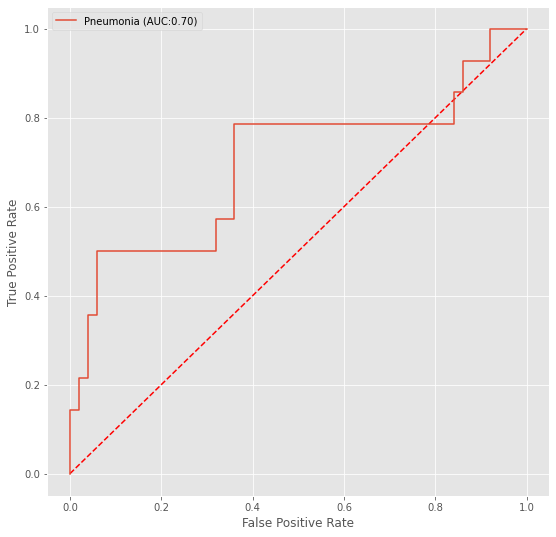

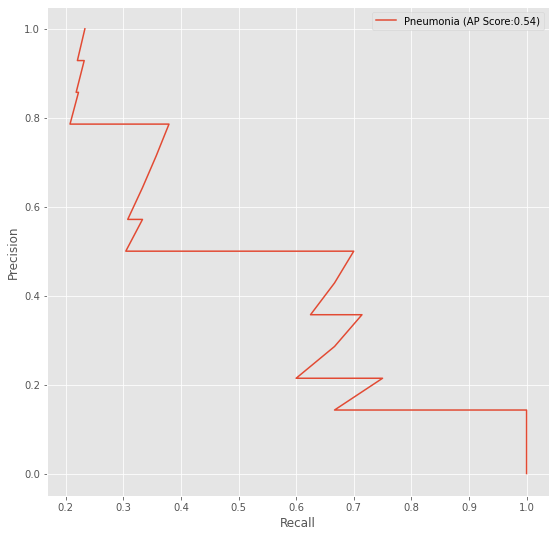

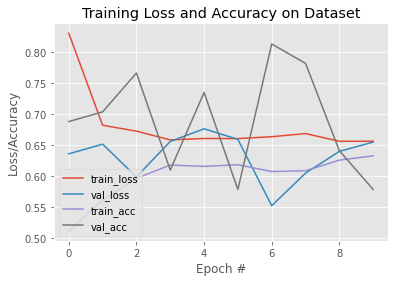

In [77]:
## plot figures

# Todo
plot_auc(valY, pred_Y)
plot_prec_recall(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

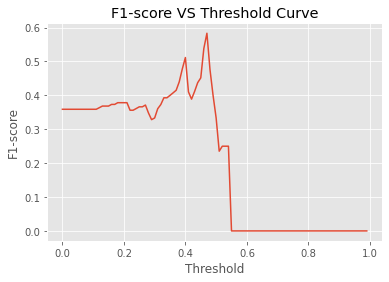

Threshold : 0.47 
Precision : 0.4594
F1-score : 0.5833
Accuracy : 0.8438


In [78]:
def plot_f1_vs_thres(true_value, predict_value) :
    best_f1 = 0    
    best_threshold = 0
    f1_values = []
    for threshold in np.arange(0,1,0.01) :
        pred = (predict_value.reshape(-1)>threshold)*1.
        f1 = f1_score(true_value, pred)
        f1_values.append(f1)
        if f1 > best_f1 :
            best_f1 = f1
            best_threshold = threshold
            
            # plot the curve
    plt.plot(np.arange(0,1,0.01), f1_values)
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.title('F1-score VS Threshold Curve')
    plt.show()
    
    # print values
    pred = (predict_value.reshape(-1)>best_threshold)*1.
    precision = average_precision_score(true_value, pred)
    accuracy = np.mean(pred==true_value)
    f1 = f1_score(true_value, pred)

    print("Threshold : %.2f "%(best_threshold))
    print("Precision : %.4f"%(precision))
    print("F1-score : %.4f"%(f1))
    print("Accuracy : %.4f"%(accuracy))
    
plot_f1_vs_thres(valY, pred_Y)

In [79]:
def optimized_threshold(true_value, predict_value):
    best_f1 = 0    
    best_threshold = 0
    f1_values = []
    for threshold in np.arange(0,1,0.01) :
        pred = (predict_value.reshape(-1)>threshold)*1.
        f1 = f1_score(true_value, pred)
        f1_values.append(f1)
        if f1 > best_f1 :
            best_threshold = threshold
    return best_threshold


threshold = optimized_threshold(valY, pred_Y)


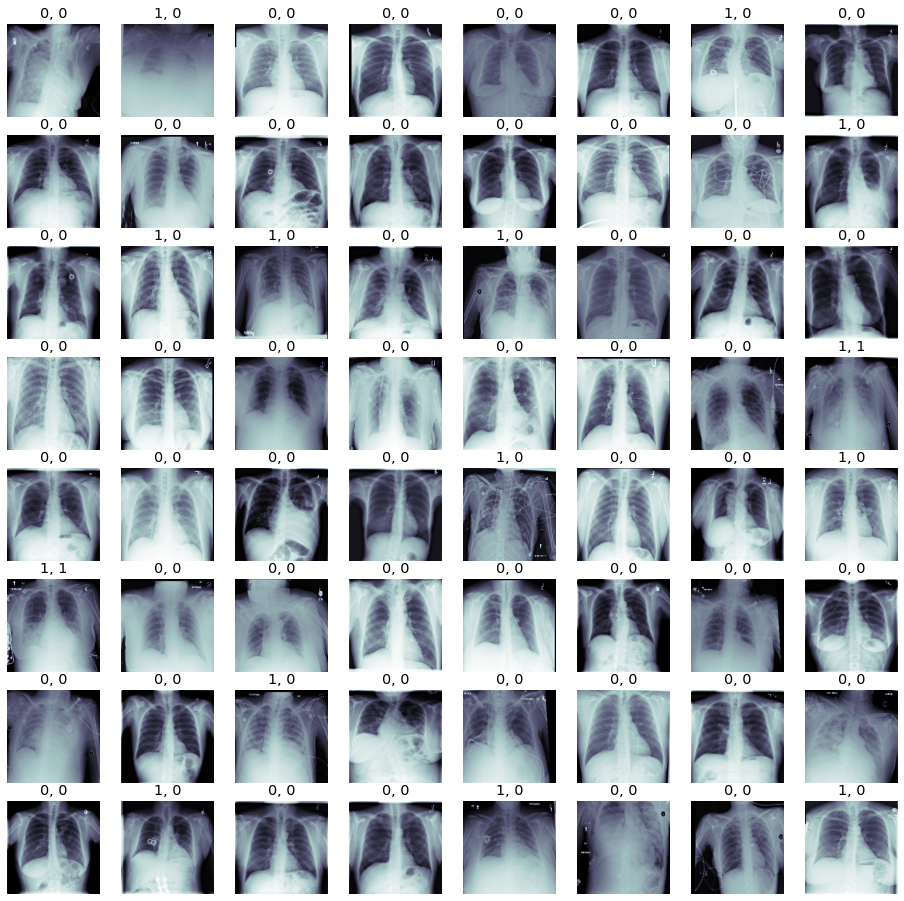

In [80]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

YOUR_THRESHOLD = threshold
testY = valY 

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [81]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)